# A notebook to identify two different anatomical structures to show in Fig. 1g

Goal: Identify two AS in the same organ that have a low cosine similarity in terms of cell type population

## `import` statements

In [167]:
from pprint import pprint
import pandas as pd
import requests
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams
from pyld import jsonld
import json

## Load hra-pop data

### AS-AS similarities

In [168]:
# make sure https://github.com/x-atlas-consortia/hra-pop/tree/main/ is cloned to the same root folder as this repository
# let's read this report that lists AS-AS similarities for all AS in HRApop
df_similarity_report = pd.read_csv("../../hra-pop/output-data/v0.10.2/reports/atlas/figure-as-as-sim.csv")

# let's sort by cosime similarity so we can find two instances with a low cosine similarity
df_similarity_report = df_similarity_report.sort_values(by="cosine_sim")

df_similarity_report_filtered = df_similarity_report[(
    df_similarity_report['organ'] == "heart") & (df_similarity_report['sex'] == "Male")]
print(df_similarity_report_filtered)

            organId  organ   sex            modality              as1_label  \
102  UBERON:0000948  heart  Male  sc_transcriptomics    left cardiac atrium   
73   UBERON:0000948  heart  Male  sc_transcriptomics    left cardiac atrium   
103  UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
75   UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
95   UBERON:0000948  heart  Male  sc_transcriptomics    left cardiac atrium   
97   UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
105  UBERON:0000948  heart  Male  sc_transcriptomics   heart left ventricle   
71   UBERON:0000948  heart  Male  sc_transcriptomics  heart right ventricle   
180  UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
99   UBERON:0000948  heart  Male  sc_transcriptomics  heart right ventricle   

                   as2_label  cosine_sim  as1_dataset_count  as2_dataset_count  
102  interventricular septum    0.318037         

### Load cell type populations for AS

In [169]:
# Get data via grlc
url = "https://grlc.io/api-git/hubmapconsortium/ccf-grlc/subdir/hra-pop//cell_types_in_anatomical_structurescts_per_as.csv"

# Make the HTTP GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV data into a DataFrame
    data = StringIO(response.text)
    df_hra_api = pd.read_csv(data)
    print(df_hra_api.head())  # Print the first few rows of the DataFrame
else:
    print(f"Failed to retrieve data: {response.status_code}")

             organ                                             as as_label  \
0  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
1  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
2  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
3  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
4  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   

      sex        tool            modality  \
0  Female  celltypist  sc_transcriptomics   
1  Female  celltypist  sc_transcriptomics   
2  Female  celltypist  sc_transcriptomics   
3  Female  celltypist  sc_transcriptomics   
4  Female  celltypist  sc_transcriptomics   

                                             cell_id           cell_label  \
0         https://purl.org/ccf/ASCTB-TEMP_smc-plpp2-         SMC (PLPP2+)   
1  https://purl.org/ccf/ASCTB-TEMP_cycling-plasma...  Cycling plasma cell   
2  https://purl.org/ccf/ASCTB

## Functions

In [170]:
def get_cell_type_population(as_label: str, tool:str, sex:str, hra_api_response: pd.DataFrame):
    """Gets the cell type population for the provided as_label (string) from the HRA API

    Args:
                    as_label (str): human-readable label for the desired anatomical structure
                    
    Returns:    
                    result (dict): with cell labels, percentages, and the anatomical structure
    """
    # set up the result as a dict
    result = {
        'Cell Type': [],
        'Anatomical Structure': [],
        'Cell Percentage': []
    } 
    
    # filter
    filtered_df = hra_api_response[(hra_api_response['as_label'] == as_label) & (hra_api_response['tool'] == tool) & (hra_api_response['sex'] == sex)]
    
    # get cell type and percentage pairs
    values = filtered_df[['cell_label', 'cell_percentage']]
    
    result['Cell Type'] = values['cell_label']
    result['Anatomical Structure'] = [as_label] * len(values['cell_label'])
    result['Cell Percentage'] = values['cell_percentage']

    return pd.DataFrame(result)

## Prepare the data for visualization

In [171]:
# Filter the right data
as_label_1 = "left cardiac atrium"
as_label_2 = "interventricular septum"
tool = "azimuth"
sex = "Female"

# get cell types and percentages for both
as_1_cells = get_cell_type_population(as_label_1, tool, sex, df_hra_api)
as_2_cells = get_cell_type_population(as_label_2, tool, sex, df_hra_api)

# set filter
as_1_cells = as_1_cells[(as_1_cells['Cell Percentage'] >= 0.05)]
as_2_cells = as_2_cells[(as_2_cells['Cell Percentage'] >= 0.05)]

# concatenate the two data frames
concatenated_df = pd.concat([as_1_cells, as_2_cells], ignore_index=True)
concatenated_df

,Cell Type,Anatomical Structure,Cell Percentage
0,Atrial Cardiomyocyte,left cardiac atrium,0.321545
1,Pericyte,left cardiac atrium,0.187391
2,Fibroblast,left cardiac atrium,0.147331
3,Capillary Endothelial,left cardiac atrium,0.124877
4,Ventricular Cardiomycoyte,interventricular septum,0.368072
5,Capillary Endothelial,interventricular septum,0.181801
6,Fibroblast,interventricular septum,0.151964
7,Pericyte,interventricular septum,0.133297


## Visualize

/var/folders/x7/ttglg94d4g500ypbdkw3__nw0000gq/T/ipykernel_45437/1131227060.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])


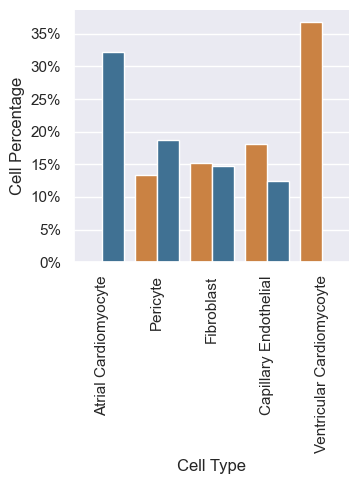

In [172]:
# Set order for bars
group_order = ['interventricular septum', 'left cardiac atrium']

# set colors
custom_palette = {'interventricular septum': '#E1812C',
                  'left cardiac atrium': '#3274A1'}

# create grouped bar graph using seaborn
plot = sns.catplot(
    data=concatenated_df,
    x='Cell Type',
    y='Cell Percentage',
    hue='Anatomical Structure',
    kind='bar',
    height=5,
    aspect=.75,
    # legend_out=False,
    legend=False,
    hue_order=group_order,
    palette=custom_palette
)

# convert y-axis to percent
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])

# rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# tighten the layout
plt.tight_layout()

# save the fig
plt.savefig("output/fig-1g.svg")
plt.savefig("output/fig-1g.pdf")
plt.savefig("output/fig-1g.png")

# render the plot
plt.show()

## Visualize cell types per dataset as bar graph

### Get dataset IDs for female heart AS from AS Cell Summaries

In [173]:
# hra-pop version to use
hra_pop_version = "v0.10.2"

# AS to show datasets for
as_to_show = as_label_2

with open(f"../../hra-pop/output-data/{hra_pop_version}/atlas-as-cell-summaries.jsonld") as f:
    data = json.load(f)

cell_summaries = [summary for summary in data["@graph"]
                  if (summary['cell_source_label'] == as_to_show) and summary['sex'] == sex and summary['annotation_method'] == tool]


pprint(cell_summaries)

[{'@type': 'CellSummary',
  'aggregated_summaries': ['https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D5$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H6$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collecti

### Get dataset IDs

In [174]:
datasets_to_keep = []
look_up = {}

for item in [id['aggregated_summaries'] for id in cell_summaries ]:
  datasets_to_keep.extend(item)

datasets_to_keep

['https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D5$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H6$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H7$left%20cardiac%20atrium']

### Make look-up from dataset to AS

In [175]:
look_up = {}

for id in datasets_to_keep:
	for summary in cell_summaries:
		if id in summary['aggregated_summaries']:
			look_up[id] = summary['cell_source_label']

look_up

{'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D5$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H6$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H7$left%20cardiac%20atrium': 

### Get cell summaries for datasets

In [176]:
# Load CTs by dataset
dataset_cell_summaries = pd.read_csv("../../hra-pop/output-data/v0.10.2/reports/atlas-ad-hoc/datasets-ct-bm-data.csv")

# filter to only keep datasets in AS
df = dataset_cell_summaries[(dataset_cell_summaries['dataset'].isin(
    datasets_to_keep)) & (dataset_cell_summaries['sex'] == sex) & (dataset_cell_summaries['tool'] == tool)]

# Select 3 columns
selected_columns = df[['dataset', 'sex', 'tool', 'cell_type_label', 'cell_type_percentage']]

# Drop duplicates
unique_df = selected_columns.drop_duplicates()

# Add column for AS
unique_df['anatomical_structure'] = unique_df['dataset'].map(look_up)

# print unique_df
unique_df

/var/folders/x7/ttglg94d4g500ypbdkw3__nw0000gq/T/ipykernel_45437/119018741.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['anatomical_structure'] = unique_df['dataset'].map(look_up)


,dataset,sex,tool,cell_type_label,cell_type_percentage,anatomical_structure
67743,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Pericyte,0.146204,left cardiac atrium
68598,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Macrophage,0.014058,left cardiac atrium
68602,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Arterial Endothelial,0.001874,left cardiac atrium
68811,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Adipocyte,0.005623,left cardiac atrium
68821,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Smooth Muscle,0.004686,left cardiac atrium
...,...,...,...,...,...,...
154083,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,B,0.008686,left cardiac atrium
154093,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Mast,0.001961,left cardiac atrium
156461,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Mesothelial,0.000560,left cardiac atrium
158693,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Atrial Cardiomyocyte,0.230769,left cardiac atrium


#### For HuBMAP

In [177]:
# ds_enriched = 

### Visualize

/var/folders/x7/ttglg94d4g500ypbdkw3__nw0000gq/T/ipykernel_45437/1843052955.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])


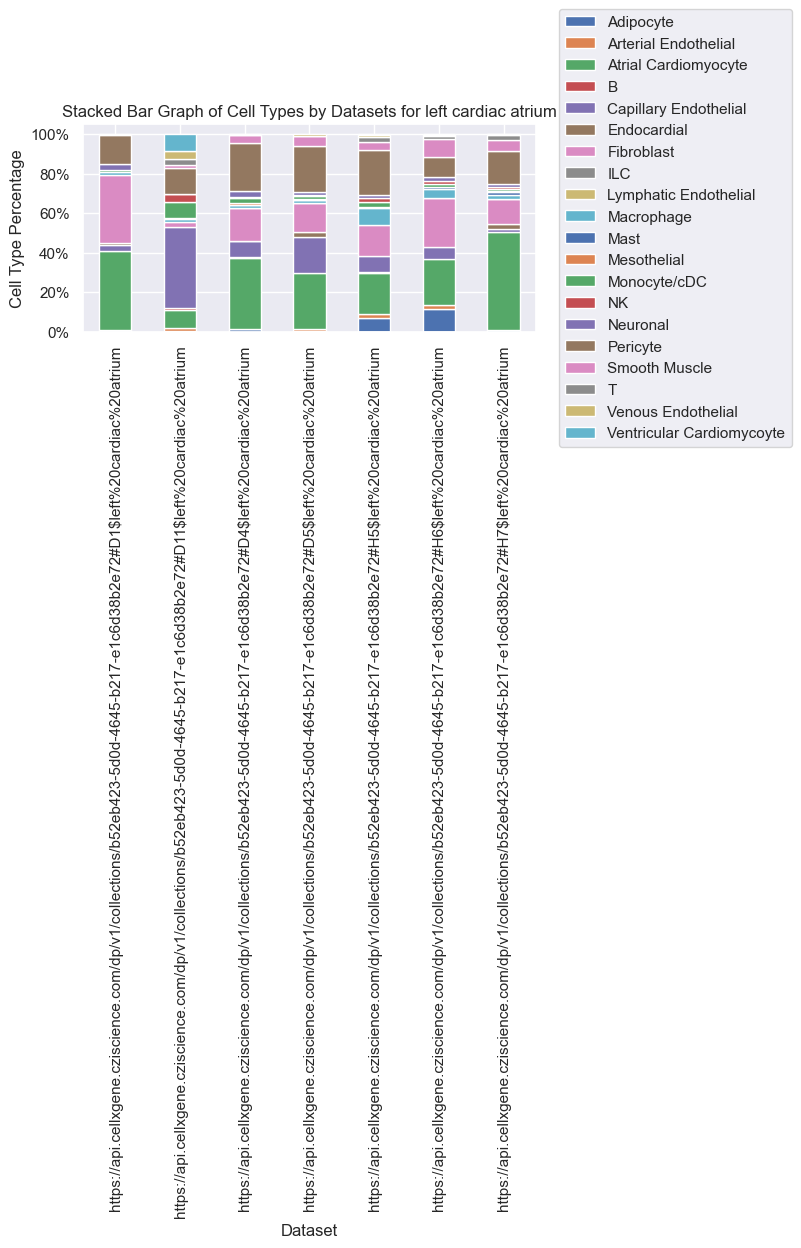

In [178]:
# Pivot the DataFrame to get Subcategories as columns
df_pivot = unique_df.pivot(index='dataset', columns='cell_type_label',
                           values='cell_type_percentage')

# Plotting
df_pivot.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Cell Type Percentage')
plt.title(f'Stacked Bar Graph of Cell Types by Datasets for {as_label_1}')

# set size
sns.set_theme(rc={'figure.figsize': (8.27, 11.7)})

# convert y-axis to percent
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])

# # rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Add a legend with bbox_to_anchor
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0.
)

# # tighten the layout
plt.tight_layout()

# render the plot
plt.show()